In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import os
import json
import librosa
import pickle
from itertools import cycle

# Set the theme for seaborn plots
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

# Mount Google Drive to access files (if you're using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Change the working directory to the TESI folder in Google Drive
tesi_path = '/content/drive/My Drive/TESI'
os.chdir(tesi_path)

# Verify the current working directory
print("Current working directory:", os.getcwd())

# Function to correct audio paths in the JSON data
def correct_paths(data, base_path):
    corrected_data = []
    for item in data:
        if 'audio' in item:
            # Replace backslashes with slashes for compatibility
            corrected_audio_path = item['audio'].replace('\\', '/')
            # Ensure the path starts with the base path
            if not corrected_audio_path.startswith(base_path):
                corrected_audio_path = os.path.join(base_path, corrected_audio_path)
            # Update the item's audio path
            item['audio'] = corrected_audio_path
        corrected_data.append(item)
    return corrected_data

# Function to process datasets
def process_dataset(json_path, base_path, task_filter, dataset_name):
    with open(json_path) as file:
        data = json.load(file)
    print(f"\nProcessing {dataset_name} dataset...")
    print(f"Total items in the {dataset_name} dataset: {len(data)}")

    # Debug: Check the keys in the first few entries
    print(f"Keys in the first item: {data[0].keys()}")

    # Correct paths
    data = correct_paths(data, base_path)

    # Filter by task
    filtered_data = [item for item in data if item['task'] in task_filter]
    print(f"Number of items found with tasks {task_filter}: {len(filtered_data)}")

    # Debug: Check the first few filtered items
    for i, item in enumerate(filtered_data[:5]):
        print(f"Filtered item {i+1}: {item}")

    # Preprocess audio files
    audio_lengths_before = []
    audio_lengths_after = []
    for idx, item in enumerate(filtered_data):
        audio_path = item['audio']
        try:
            audio, sr = librosa.load(audio_path, sr=44100)
            length_before = len(audio) / sr
            audio_lengths_before.append(length_before)

            # Trim silence
            audio_trimmed, _ = librosa.effects.trim(audio, top_db=20)
            length_after = len(audio_trimmed) / sr
            audio_lengths_after.append(length_after)

            # Update the dataset with trimmed audio
            item['audio'] = audio_trimmed

            # Debug every 10 files
            if (idx + 1) % 10 == 0:
                print(f"Processed {idx + 1}/{len(filtered_data)} files from {dataset_name}")
        except Exception as e:
            print(f"Error processing file {audio_path}: {e}")

    print(f"Number of audio files successfully processed in {dataset_name}: {len(audio_lengths_after)}")
    return filtered_data, audio_lengths_before, audio_lengths_after

# Process each dataset
newdata = []

pcgita_data, pcgita_lengths_before, pcgita_lengths_after = process_dataset(
    'PCGITA.json', 'DATI', ['vowel','vowels'], 'PC-GITA'
)
newdata.extend(pcgita_data)

dimauro_data, dimauro_lengths_before, dimauro_lengths_after = process_dataset(
    'DIMAURO_new.json', 'DATI', ['vowels', 'vowelA'], 'DIMAURO'
)
newdata.extend(dimauro_data)

molinette_data, molinette_lengths_before, molinette_lengths_after = process_dataset(
    'MOLINETTE_combined.json', 'DATI', ['vowel', 'vowels'], 'MOLINETTE'
)
newdata.extend(molinette_data)

# Debug: Check final dataset size and first few items
print(f"\nTotal size of the combined dataset: {len(newdata)}")
print("First few items in the combined dataset:")
for i, item in enumerate(newdata[:5]):
    print(f"Item {i+1}: {item}")

# Save combined dataset to pickle file
file_path_updated = '/content/drive/MyDrive/TESI/newdata_updated.pkl'
with open(file_path_updated, 'wb') as f:
    pickle.dump(newdata, f)

print(f"\nCombined dataset successfully saved to {file_path_updated}")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/My Drive/TESI

Processing PC-GITA dataset...
Total items in the PC-GITA dataset: 6090
Keys in the first item: dict_keys(['audio', 'id', 'label', 'task', 'vowel'])
Number of items found with tasks ['vowel']: 1472
Filtered item 1: {'audio': 'DATI/PC-GITA/Vowels/hc/A/AVPEPUDEAC0001a1.wav', 'id': 'AVPEPUDEAC0001', 'label': 0, 'task': 'vowel', 'vowel': 'a'}
Filtered item 2: {'audio': 'DATI/PC-GITA/Vowels/hc/A/AVPEPUDEAC0001a2.wav', 'id': 'AVPEPUDEAC0001', 'label': 0, 'task': 'vowel', 'vowel': 'a'}
Filtered item 3: {'audio': 'DATI/PC-GITA/Vowels/hc/A/AVPEPUDEAC0001a3.wav', 'id': 'AVPEPUDEAC0001', 'label': 0, 'task': 'vowel', 'vowel': 'a'}
Filtered item 4: {'audio': 'DATI/PC-GITA/Vowels/hc/A/AVPEPUDEAC0003a1.wav', 'id': 'AVPEPUDEAC0003', 'label': 0, 'task': 'vowel', 'vowel': 'a'}
Filtered item 5: {'audio': 'DATI/PC-GITA/Vowe

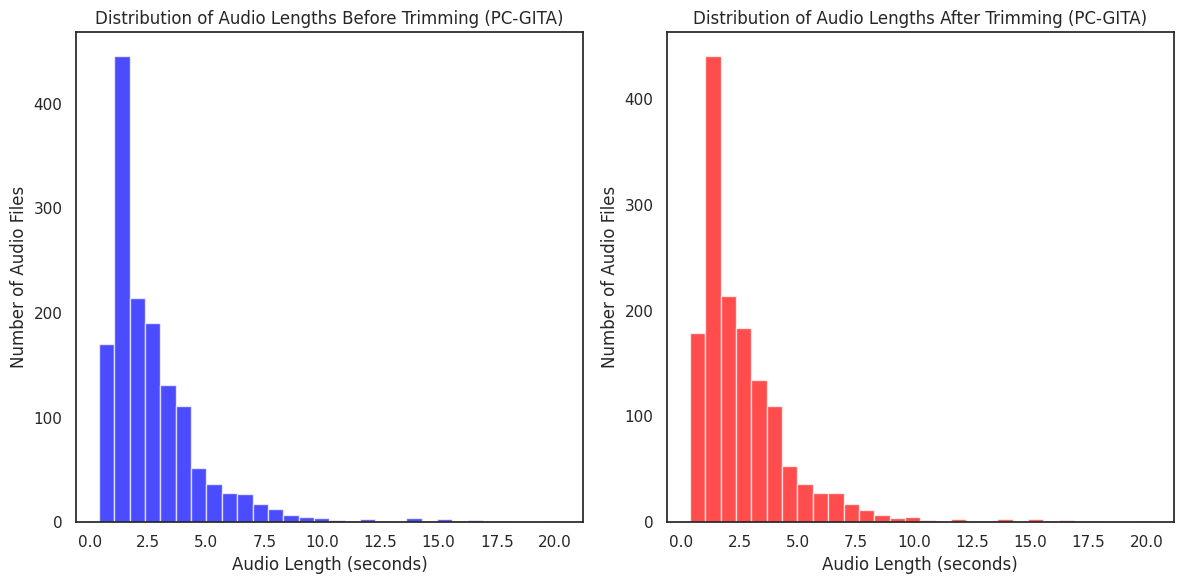

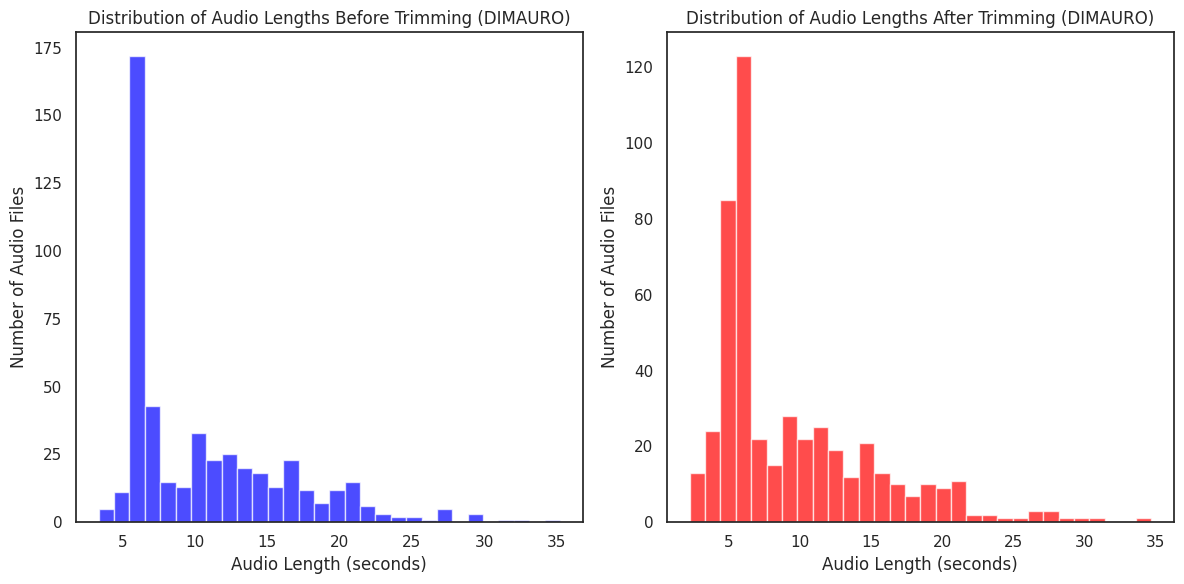

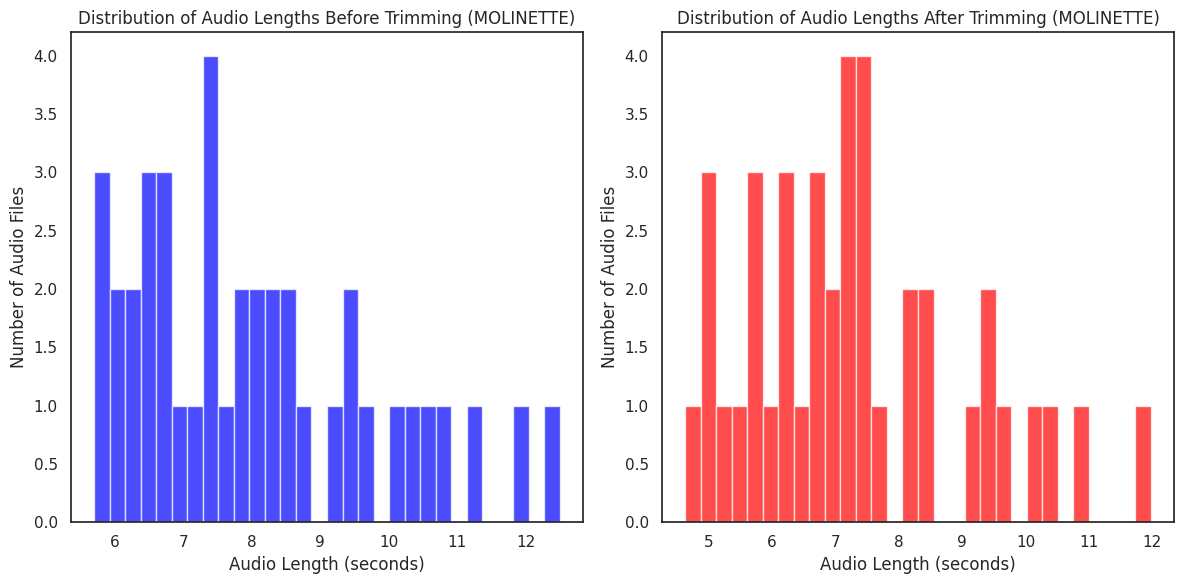

In [ ]:
# Plot histograms for each dataset
datasets = [
    ('PC-GITA', pcgita_lengths_before, pcgita_lengths_after),
    ('DIMAURO', dimauro_lengths_before, dimauro_lengths_after),
    ('MOLINETTE', molinette_lengths_before, molinette_lengths_after)
]

for name, lengths_before, lengths_after in datasets:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(lengths_before, bins=30, alpha=0.7, color='blue')
    plt.xlabel('Audio Length (seconds)')
    plt.ylabel('Number of Audio Files')
    plt.title(f'Distribution of Audio Lengths Before Trimming ({name})')

    plt.subplot(1, 2, 2)
    plt.hist(lengths_after, bins=30, alpha=0.7, color='red')
    plt.xlabel('Audio Length (seconds)')
    plt.ylabel('Number of Audio Files')
    plt.title(f'Distribution of Audio Lengths After Trimming ({name})')

    plt.tight_layout()
    plt.show()

In [ ]:
import pickle

# Percorso del file .pkl
file_path_updated = '/content/drive/MyDrive/TESI/newdata_updated.pkl'

# Carica il file .pkl
with open(file_path_updated, 'rb') as f:
    newdata = pickle.load(f)

# Numero totale di elementi nel dataset
print(f"Numero totale di elementi in newdata: {len(newdata)}")

# Verifica delle chiavi presenti nei dizionari
print("\nChiavi presenti nel primo elemento:")
print(newdata[0].keys())

# Controllo dei primi 5 elementi
print("\nPrimi 5 elementi in newdata:")
for i, item in enumerate(newdata[:5]):
    print(f"Elemento {i + 1}: {item}")

# Statistiche su alcune chiavi
if 'audio' in newdata[0]:
    print("\nVerifica del campo 'audio':")
    print(f"Primo percorso audio: {newdata[0]['audio']}")

if 'task' in newdata[0]:
    print("\nDistribuzione dei task:")
    tasks = [item['task'] for item in newdata]
    print({task: tasks.count(task) for task in set(tasks)})

if 'updrs' in newdata[0]:
    print("\nDistribuzione UPDRS (se presente):")
    updrs_levels = [item['updrs'] for item in newdata if 'updrs' in item]
    print({level: updrs_levels.count(level) for level in set(updrs_levels)})


Numero totale di elementi in newdata: 1997

Chiavi presenti nel primo elemento:
dict_keys(['audio', 'id', 'label', 'task', 'vowel'])

Primi 5 elementi in newdata:
Elemento 1: {'audio': array([-0.0057373 , -0.00549316, -0.00564575, ...,  0.01092529,
        0.01138306,  0.01165771], dtype=float32), 'id': 'AVPEPUDEAC0001', 'label': 0, 'task': 'vowel', 'vowel': 'a'}
Elemento 2: {'audio': array([0.03231812, 0.02920532, 0.02584839, ..., 0.00427246, 0.0043335 ,
       0.0043335 ], dtype=float32), 'id': 'AVPEPUDEAC0001', 'label': 0, 'task': 'vowel', 'vowel': 'a'}
Elemento 3: {'audio': array([-0.00592041, -0.0065918 , -0.00650024, ...,  0.00778198,
        0.00894165,  0.00897217], dtype=float32), 'id': 'AVPEPUDEAC0001', 'label': 0, 'task': 'vowel', 'vowel': 'a'}
Elemento 4: {'audio': array([-0.06027222, -0.0597229 , -0.05828857, ...,  0.02731323,
        0.03921509,  0.05010986], dtype=float32), 'id': 'AVPEPUDEAC0003', 'label': 0, 'task': 'vowel', 'vowel': 'a'}
Elemento 5: {'audio': array([-0